In [1]:
import pandas as pd
import zipfile
import os
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import anndata as ad
import seaborn as sns
from scipy import stats
import matplotlib as mpl
pd.set_option('display.max_rows', 250)
plt.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'NimbusSanL'

/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/_utils/__init__.py:33: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/__init__.py:24: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/readwrite.py:16: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):


In [3]:
cluster_nde75_ntotal50

,target_contrast_gene_name,culture_condition,target_contrast,chunk,n_cells_target,target_contrast_corrected,target_contrast_gene_name_corrected,hdbscan
ENSG00000104368_Stim8hr,PLAT,Stim8hr,ENSG00000104368,0,411.0,ENSG00000104368,PLAT,21
ENSG00000128607_Stim8hr,KLHDC10,Stim8hr,ENSG00000128607,0,1257.0,ENSG00000128607,KLHDC10,35
ENSG00000163600_Stim8hr,ICOS,Stim8hr,ENSG00000163600,0,658.0,ENSG00000163600,ICOS,35
ENSG00000174177_Stim8hr,CTU2,Stim8hr,ENSG00000174177,0,500.0,ENSG00000174177,CTU2,33
ENSG00000108064_Stim48hr,TFAM,Stim48hr,ENSG00000108064,1,414.0,ENSG00000108064,TFAM,58
...,...,...,...,...,...,...,...,...
ENSG00000134323_Rest,MYCN,Rest,ENSG00000134323,680,924.0,ENSG00000134323,MYCN,28
ENSG00000137265_Rest,MUM1,Rest,ENSG00000137265,680,803.0,ENSG00000137265,IRF4,106
ENSG00000157426_Rest,AASDH,Rest,ENSG00000157426,680,651.0,ENSG00000157426,AASDH,101
ENSG00000160050_Rest,CCDC28B,Rest,ENSG00000160050,680,54.0,ENSG00000160050,CCDC28B,27


In [4]:
distribution_of_genes_per_cluster = cluster_nde75_ntotal50.groupby('hdbscan')['target_contrast_gene_name_corrected'].nunique()

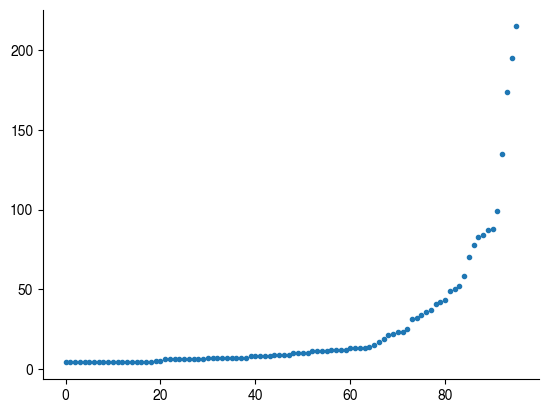

In [15]:
plt.plot(np.sort(distribution_of_genes_per_cluster[1:][distribution_of_genes_per_cluster>=4]), '.')
sns.despine()

In [2]:
# Load clustering results
cluster_nde75_ntotal50 = pd.read_csv('../../../../3_expts/processed_data/analysis_largefiles/nde75ntotal50_varfiltered_simple_clustering.csv', index_col=0)
de_summary_stats = pd.read_csv('../../../../3_expts/processed_data/CD4i_final/DE_results_all_confounders/DE_summary_stats_per_target_corrected.csv', index_col=0)
enrichment_df = pd.read_csv('results/clustering_nde75ntotal50_reg_and_downstream.csv', index_col=0)
cluster_df = pd.read_csv('./results/nde75ntotal50_cluster_specificity.csv', index_col=0)
mask = ((cluster_df.cluster_gene_size>5) & (cluster_df.corr_max>0.1)) | ((cluster_df.cluster_gene_size>=4) & (cluster_df.corr_max>0.3)) 
cluster_df_filtered = cluster_df[mask].copy()

In [3]:
# Load HPA expression results
file_name = "../../metadata/rna_tissue_consensus.tsv.zip"
df_exp = pd.read_csv(file_name, sep='\t', compression='zip')
df_exp['log1p_nTPM'] = np.log1p(df_exp['nTPM'])
df_exp = df_exp[df_exp['Gene'].isin(cluster_nde75_ntotal50.target_contrast_corrected.unique().tolist())].copy()

### First calculate the expression specificity index (tau) and tissue expression enrichment for selective genes

In [24]:
# Tissue expression enrichment fold change threshold
LFC_THRESHOLD = 2.5
# Threshold for large tau
TAU_THRESHOLD = 0.6

In [25]:
def calculate_tau(row):
    """
    Calculates Tau specificity index.
    Formula: Sum(1 - (xi / max_x)) / (N - 1)
    """
    if row.max() == 0:
        return 0.0
    
    x_hat = row / row.max()
    tau = (1 - x_hat).sum() / (len(row) - 1)
    return tau

def analyze_gene_set(gene_set_name, gene_names_list, final_df, tau_threshold=0.5):
    """
    Calculates the fraction of genes above a Tau threshold and the fraction
    enriched in each tissue for a given gene set.
    """
    # Filter the final_df for the genes in the set using the 'Gene name' level of the MultiIndex
    set_data = final_df[final_df.index.get_level_values('Gene').isin(gene_names_list)]

    N = len(set_data)
    
    # 1. Fraction of genes with Tau_Index > threshold
    tau_frac = (set_data['Tau_Index'] > tau_threshold).sum() / N
    
    result_dict = {'large_tau_fraction': tau_frac}

    # 2. Fraction of genes enriched in each tissue
    # Select columns ending with ' (Enriched)'
    enrichment_cols = [col for col in set_data.columns if col.endswith(' (Enriched)')]
    
    for col in enrichment_cols:
        # .sum() works on boolean columns (True=1, False=0). Divide by N to get fraction.
        enrichment_frac = set_data[col].sum() / N
        
        # Clean up column name for final output (e.g., 'adipose tissue (Enriched)' -> 'adipose tissue_Enrich_Fraction')
        clean_col = col.replace(' (Enriched)', '')
        result_dict[clean_col] = enrichment_frac
        
    return pd.Series(result_dict, name=gene_set_name)

In [26]:
# Pivot to get Genes x Tissues matrix using log1p_nTPM
tau_pivot = df_exp.pivot_table(
    index=['Gene', 'Gene name'], 
    columns='Tissue', 
    values='log1p_nTPM', 
    fill_value=0
)

# Apply Tau calculation row-wise
tau_series = tau_pivot.apply(calculate_tau, axis=1)
tau_series.name = 'Tau_Index'

# Calculate Log2 Fold Change
median_ntpm = df_exp.groupby(['Gene', 'Gene name'])['nTPM'].transform('median')
df_exp['LFC'] = np.log2((df_exp['nTPM'] + 1e-6) / (median_ntpm + 1e-6))
df_exp['Enriched'] = df_exp['LFC'] > LFC_THRESHOLD
# Pivot
lfc_pivot = df_exp.pivot_table(
    index=['Gene', 'Gene name'], 
    columns='Tissue', 
    values='LFC'
).add_suffix(' (LFC)')

enrich_pivot = df_exp.pivot_table(
    index=['Gene', 'Gene name'], 
    columns='Tissue', 
    values='Enriched'
).add_suffix(' (Enriched)')
lfc_pivot = lfc_pivot.fillna(0)
enrich_pivot = enrich_pivot.fillna(False).astype(bool)
final_df = pd.concat([tau_series, lfc_pivot, enrich_pivot], axis=1)
final_df = final_df.reindex(sorted(final_df.columns), axis=1)

cols = ['Tau_Index'] + [c for c in final_df.columns if c != 'Tau_Index']
final_df = final_df[cols]

In [30]:
gene_names_list = cluster_nde75_ntotal50[cluster_nde75_ntotal50.hdbscan==82].target_contrast_corrected.unique()
np.sum(enrich_pivot[enrich_pivot.index.get_level_values('Gene').isin(gene_names_list)][['lymph node (Enriched)',
                                                                                 'tonsil (Enriched)',
                                                                                'spleen (Enriched)',
                                                                                'bone marrow (Enriched)',
                                                                                 'thymus (Enriched)']].sum(1)>0)

2

In [11]:
# Check fraction of genes that have large tau, and have tissue expression enrichment in each tissue
num_clusters = 111
gene_sets = {}
for cl in range(num_clusters):
    gene_ids = cluster_nde75_ntotal50[cluster_nde75_ntotal50.hdbscan==cl].target_contrast_corrected.unique().tolist()
    gene_sets[cl] = gene_ids

results = []

for set_id, gene_list in gene_sets.items():
    set_result = analyze_gene_set(set_id, gene_list, final_df, tau_threshold=TAU_THRESHOLD)
    results.append(set_result)

gene_set_analysis_df = pd.DataFrame(results)
#gene_set_analysis_df = gene_set_analysis_df.reset_index().rename(columns={'index': 'cluster'})

### Get clusters with gene set enrichment or without gene set enrichment (CORUM, STRINGDB, KEGG, REACTOME)

In [12]:
fdr_thres = 0.05
overlap_size_thres = 2
overlap_fraction_thres = 0.15

In [13]:
columns_to_keep = ['cluster_gene_size',
                   'overlap_fraction_corum_reg',
                   'overlap_size_corum_reg',
                   'fdr_corum_reg',
                   'overlap_fraction_stringdb_reg',
                   'overlap_size_stringdb_reg',
                   'fdr_stringdb_reg',
                   'overlap_fraction_kegg_reg',
                   'overlap_size_kegg_reg',
                   'fdr_kegg_reg',
                   'overlap_fraction_reactome_reg',
                   'overlap_size_reactome_reg',
                   'fdr_reactome_reg']
enrichment_df_filtered = enrichment_df.set_index('cluster').loc[cluster_df_filtered.index, columns_to_keep]

def add_enrichment_column(df):
    """
    Criteria for enrichment: 
    1. enrichment significance fdr < fdr_thres;
    2. overlap gene size > overlap_size_thres;
    3. overlap gene fraction > overlap_fraction_thres;
    for any database
    """
    suffixes = [col.replace('fdr_', '') for col in df.columns if col.startswith('fdr_')]
    df['enrichment'] = False
    for suffix in suffixes:
        fdr_col = f'fdr_{suffix}'
        size_col = f'overlap_size_{suffix}'
        frac_col = f'overlap_fraction_{suffix}'
        if size_col in df.columns and frac_col in df.columns:
            condition_met = (
                (df[fdr_col] < fdr_thres) & 
                (df[size_col] > overlap_size_thres) & 
                (df[frac_col] > overlap_fraction_thres)
            )
            df['enrichment'] = df['enrichment'] | condition_met
    return df

enrichment_df_filtered = add_enrichment_column(enrichment_df_filtered)

In [14]:
cluster_df_filtered.head(5)

,cluster_gene_size,corr_rest,corr_stim8hr,corr_stim48hr,corr_max,corr_std,corr_cov,corr_min,corr_mean,condition_specificity
hdbscan,,,,,,,,,,
0,7,0.406482,0.512976,0.496743,0.512976,0.057376,0.121541,0.406482,0.472067,across_condition
2,11,0.261680,0.304254,0.281659,0.304254,0.021300,0.075390,0.261680,0.282531,across_condition
6,6,0.281898,0.284300,0.202250,0.284300,0.046693,0.182289,0.202250,0.256149,across_condition
7,10,0.375615,0.412734,0.250229,0.412734,0.085154,0.245973,0.250229,0.346192,across_condition
8,7,0.287590,0.344533,0.272032,0.344533,0.038169,0.126644,0.272032,0.301385,across_condition


In [15]:
cluster_df_filtered.loc[[100,103,92,62]]

,cluster_gene_size,corr_rest,corr_stim8hr,corr_stim48hr,corr_max,corr_std,corr_cov,corr_min,corr_mean,condition_specificity
hdbscan,,,,,,,,,,
100,13,0.044663,0.130695,0.192627,0.192627,0.074308,0.605800,0.044663,0.122662,Stim48hr
103,4,-0.011771,0.003805,0.421378,0.421378,0.245706,1.783009,-0.011771,0.137804,Stim48hr
92,4,0.348438,0.136701,0.037292,0.348438,0.158916,0.912558,0.037292,0.174144,Rest
62,4,0.493864,0.394857,0.290318,0.493864,0.101785,0.258988,0.290318,0.393013,across_condition


### Plot the tissue expression enrichment results

In [16]:
tissue_spec_vs_enrichment = pd.merge(enrichment_df_filtered[['cluster_gene_size', 'enrichment']], gene_set_analysis_df, how='inner', left_index=True, right_index=True)
tissue_spec_vs_enrichment = tissue_spec_vs_enrichment.reset_index()
tissue_spec_vs_enrichment = tissue_spec_vs_enrichment.rename(columns={'index': 'cluster'})

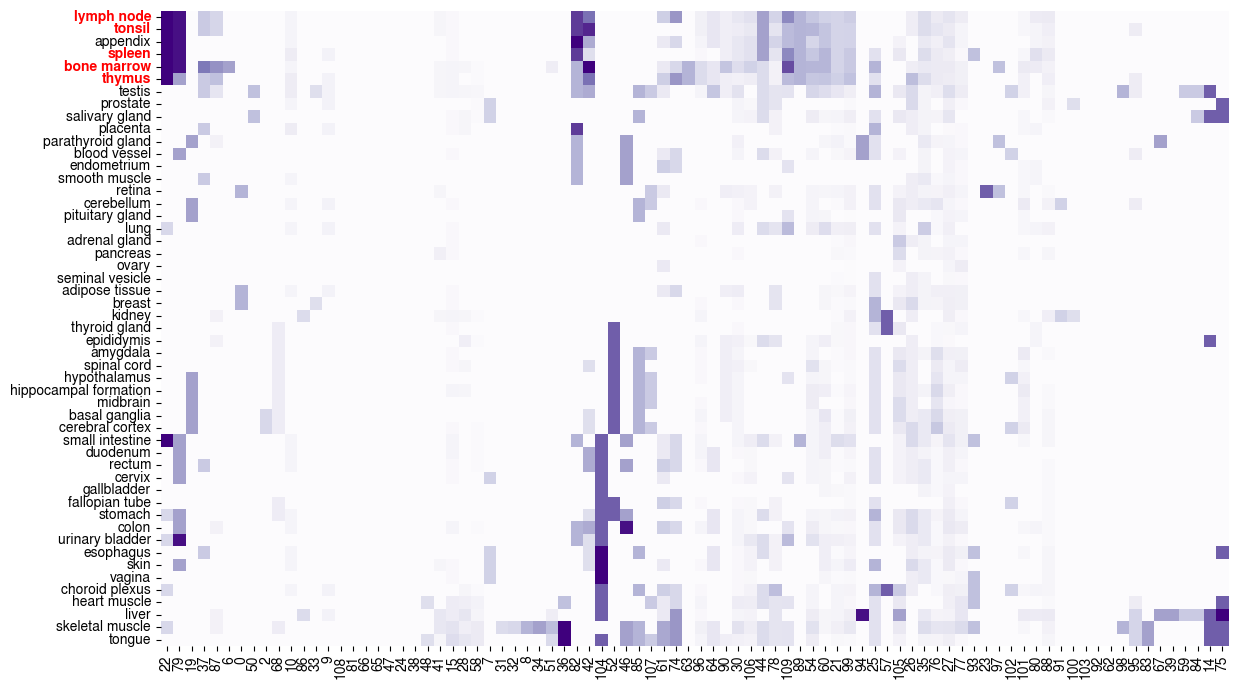

In [18]:
thres = 0.35
# Do a hierachical clustering on rows and columns
df = tissue_spec_vs_enrichment.set_index('cluster').iloc[:,3:].T.copy()
cm = sns.clustermap(df,
                    method='complete',
                    metric='euclidean',
                    row_cluster=True,
                    col_cluster=True,
                   yticklabels=True,
                    figsize=(15,6),
                   xticklabels=tissue_spec_vs_enrichment['enrichment'])
plt.close(cm.fig)

# Preserve hierachical clustering orders, separate by enrichment or not
reordered_cols = df.columns[cm.dendrogram_col.reordered_ind]
reordered_rows = df.index[cm.dendrogram_row.reordered_ind]
true_cols = [c for c in reordered_cols if tissue_spec_vs_enrichment.set_index('cluster').loc[c, 'enrichment']]
false_cols = [c for c in reordered_cols if not tissue_spec_vs_enrichment.set_index('cluster').loc[c, 'enrichment']]
new_col_order = true_cols + false_cols

plt.figure(figsize=(12.5, 7))
ax = sns.heatmap(df.loc[reordered_rows, new_col_order], 
                 vmin=0,
                 vmax=thres, 
                 cmap='Purples',
                 xticklabels=True,
                 yticklabels=True,
                 cbar=False,)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center', fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


# Highlighting lymphoid tissues
indices_to_highlight = [0, 1, 3, 4, 5] 
ytick_labels = ax.get_yticklabels()

for i, label in enumerate(ytick_labels):
    if i in indices_to_highlight:
        # Change color to red and weight to bold
        label.set_color('red')
        label.set_fontweight('bold')

ax.set_xlabel('')
        
plt.tight_layout()
plt.savefig('./results/tissue_specificity_heatmap.pdf', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_73515/4141898304.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


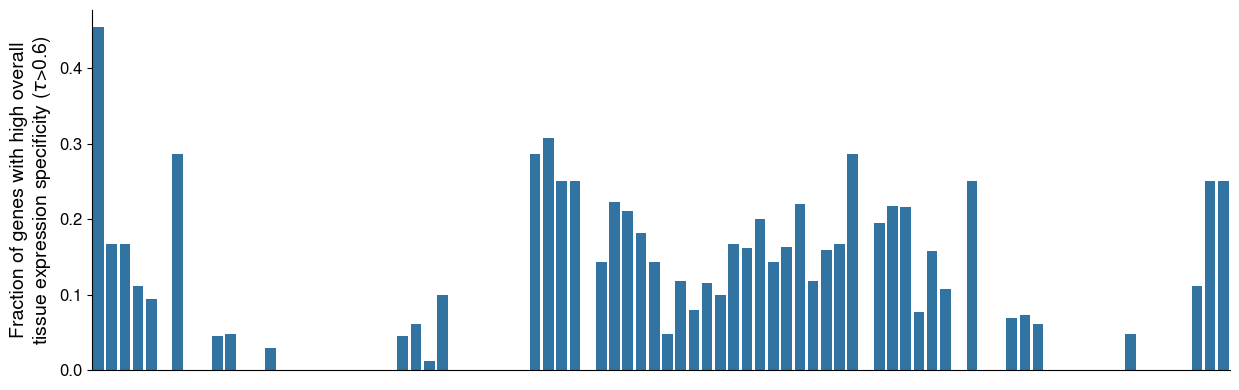

In [81]:
plt.figure(figsize=(12.5, 4))
ax = sns.barplot(tissue_spec_vs_enrichment,
                 x='cluster', 
                 y='large_tau_fraction',
                 order=new_col_order)

ax.set_xticklabels([])
ax.set_xlabel('')
ax.tick_params(axis='x', length=0)
#ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center', fontsize=8)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
ax.set_ylabel(f'Fraction of genes with high overall\n'+r'tissue expression specificity ($\tau$>'+str(TAU_THRESHOLD)+')', fontsize=14)
sns.despine()
plt.tight_layout()
plt.savefig('./results/tissue_specificity_tau_barplot.pdf', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_73515/497484543.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center', fontsize=8)
/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_73515/497484543.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


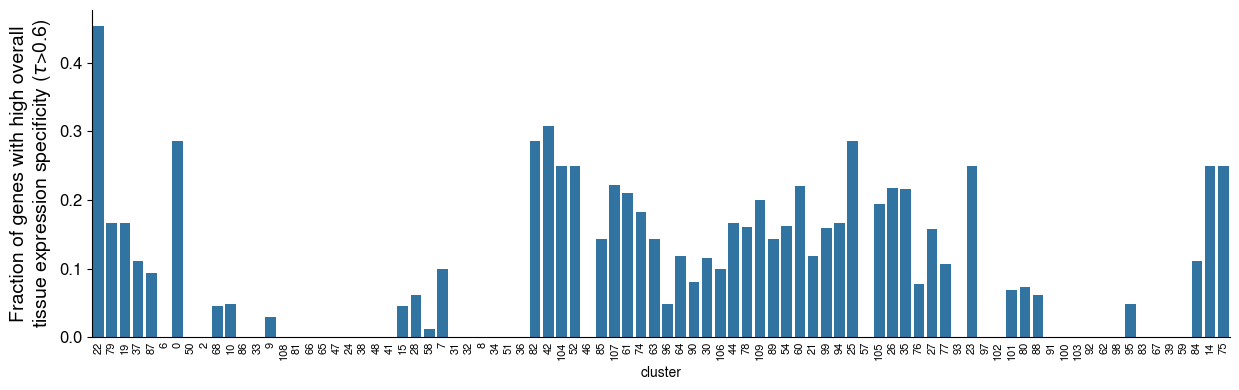

In [83]:
plt.figure(figsize=(12.5, 4))
ax = sns.barplot(tissue_spec_vs_enrichment,
                 x='cluster', 
                 y='large_tau_fraction',
                 order=new_col_order)

#ax.set_xticklabels([])
#ax.set_xlabel('')
ax.tick_params(axis='x', length=0)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center', fontsize=8)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
ax.set_ylabel(f'Fraction of genes with high overall\n'+r'tissue expression specificity ($\tau$>'+str(TAU_THRESHOLD)+')', fontsize=14)
sns.despine()
plt.tight_layout()
#plt.savefig('./results/tissue_specificity_tau_barplot.pdf', dpi=600, bbox_inches='tight', pad_inches=0)
#plt.show()

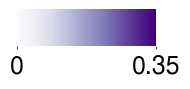

In [88]:
thres_0 = 0
thres_1 = 0.35
orientation = 'bottom'
cmap = sns.color_palette("Purples", as_cmap=True)
norm = mpl.colors.Normalize(vmin=thres_0, vmax=thres_1)

# Create small horizontal figure
fig, ax = plt.subplots(figsize=(2, 1))

# Draw the colorbar
cb = mpl.colorbar.ColorbarBase(
    ax,
    cmap=cmap,
    norm=norm,
    orientation='horizontal'
)

# Remove outline and tidy style
cb.outline.set_visible(False)
cb.ax.tick_params(labelsize=18, width=0.5, length=2)
cb.set_ticks([thres_0, thres_1])
cb.set_ticklabels([str(thres_0), str(thres_1)])

cb.ax.xaxis.set_ticks_position(orientation)

# Adjust layout
plt.subplots_adjust(left=0.25, right=0.95, top=0.7, bottom=0.45)
plt.tight_layout()
plt.savefig('./results/colorbar_'+str(thres_0)+'_'+str(thres_1)+orientation+'.pdf', dpi=600, bbox_inches='tight', pad_inches=0)

In [102]:
stats.mannwhitneyu(tissue_spec_vs_enrichment[tissue_spec_vs_enrichment.enrichment].large_tau_fraction, 
                   tissue_spec_vs_enrichment[~tissue_spec_vs_enrichment.enrichment].large_tau_fraction,
                  alternative='less')

MannwhitneyuResult(statistic=385.0, pvalue=2.3776201151611315e-05)